In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text
from utils.database import get_sqlalchemy_conn

# Initialize connection
engine = get_sqlalchemy_conn()

Connected to SQL Server: Microsoft SQL Server 2022 (RTM) - 16.0.1000.6 (X64) 
	Oct  8 2022 05:58:25 
	Copyright (C) 2022 Microsoft Corporation
	Express Edition (64-bit) on Windows 10 Pro 10.0 <X64> (Build 19045: )



In [2]:
#return on equity calculation
roe_query = text("""                                                        
    SELECT 
        i.date,
        i.net_income,
        b.stockholders_equity,
        ROUND(i.net_income / NULLIF(b.stockholders_equity, 0), 2) AS roe
    FROM income_statement i
    JOIN balance_sheet b ON i.date = b.date
""")

roe_df = pd.read_sql(roe_query, engine)
roe_df.to_csv("C:/Users/abc/Desktop/Projects/corporate-fin-analysis/data_processed/roe_results.csv", index=False)
print(roe_df.head())

         date    net_income  stockholders_equity   roe
0  2020-09-30           NaN                  NaN   NaN
1  2021-09-30  9.468000e+10         6.309000e+10  1.50
2  2022-09-30  9.980300e+10         5.067200e+10  1.97
3  2023-09-30  9.699500e+10         6.214600e+10  1.56
4  2024-09-30  9.373600e+10         5.695000e+10  1.65


In [3]:
#Calculate Current Ratio
current_ratio_query = text("""                                              
    SELECT 
        date,
        current_assets,
        current_liabilities,
        ROUND(current_assets / NULLIF(current_liabilities, 0), 2) AS current_ratio
    FROM balance_sheet
""")

current_ratio_df = pd.read_sql(current_ratio_query, engine)
current_ratio_df.to_csv("C:/Users/abc/Desktop/Projects/corporate-fin-analysis/data_processed/current_ratios.csv", index=False)
print(current_ratio_df.head())

         date  current_assets  current_liabilities  current_ratio
0  2024-09-30    1.529870e+11         1.763920e+11           0.87
1  2023-09-30    1.435660e+11         1.453080e+11           0.99
2  2022-09-30    1.354050e+11         1.539820e+11           0.88
3  2021-09-30    1.348360e+11         1.254810e+11           1.07
4  2020-09-30             NaN                  NaN            NaN


In [4]:
#Year-over-Year Revenue Growth Calculatio
yoy_revenue_query = text("""                                                
    SELECT                                                                          
        date,
        total_revenue,
        LAG(total_revenue) OVER (ORDER BY date) AS prev_revenue,
        ROUND(
            (total_revenue - LAG(total_revenue) OVER (ORDER BY date)) / 
            NULLIF(LAG(total_revenue) OVER (ORDER BY date), 0) * 100, 
        2
        ) AS yoy_growth_percent
    FROM income_statement
""")

yoy_revenue_df = pd.read_sql(yoy_revenue_query, engine)
yoy_revenue_df.to_csv("C:/Users/abc/Desktop/Projects/corporate-fin-analysis/data_processed/yoy_revenue_growth.csv", index=False)


In [5]:
balance_df = pd.read_sql(text("SELECT date, total_assets FROM balance_sheet"), engine)
balance_df["yoy_asset_growth"] = balance_df["total_assets"].pct_change() * 100
balance_df.to_csv("../data_processed/yoy_asset_growth.csv", index=False)

C:\Users\abc\AppData\Local\Temp\ipykernel_5648\3212396410.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  balance_df["yoy_asset_growth"] = balance_df["total_assets"].pct_change() * 100


In [6]:
from scipy import stats

# Load data
income_df = pd.read_sql(text("SELECT date, net_income FROM income_statement"), engine)
income_df = income_df.sort_values(by="date")
# Calculate Z-scores
income_df["net_income_zscore"] = stats.zscore(income_df["net_income"])
income_df["is_anomaly"] = income_df["net_income_zscore"].abs() > 3  # 3σ threshold

# Save anomalies
anomalies = income_df[income_df["is_anomaly"]]
anomalies.to_csv("../data_processed/net_income_anomalies.csv", index=False)

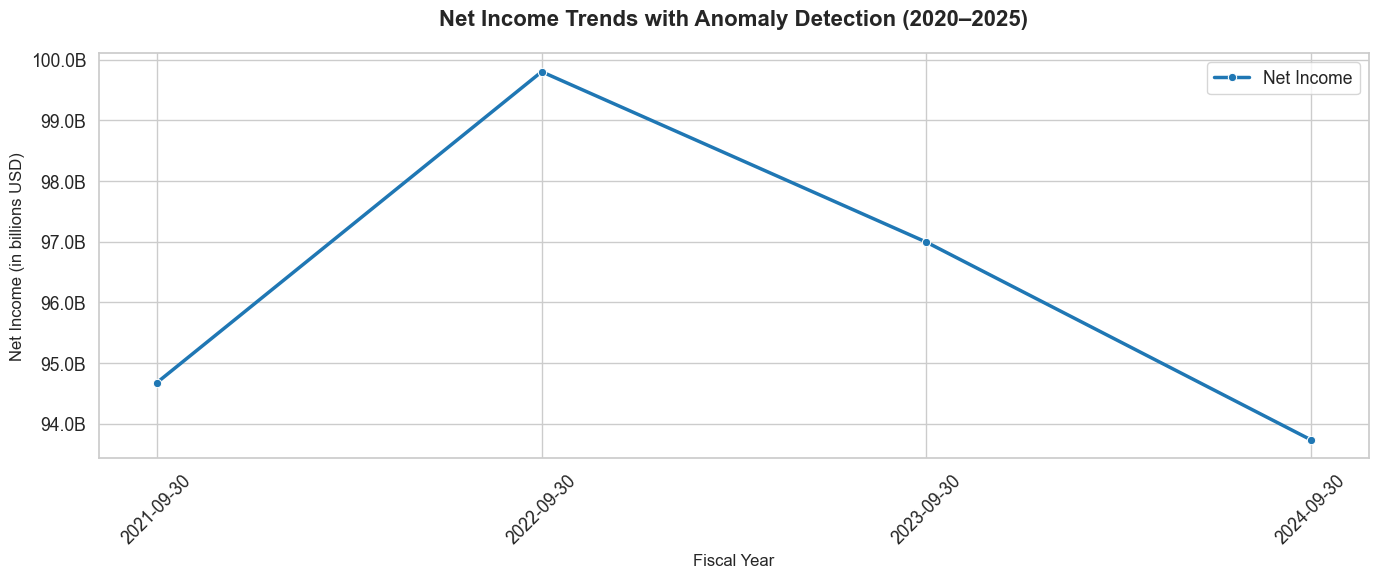

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Set modern plot style
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.15)

# Initialize figure
plt.figure(figsize=(14, 6))

# Main net income line
sns.lineplot(
    data=income_df,
    x="date",
    y="net_income",
    label="Net Income",
    color="#1f77b4",
    linewidth=2.5,
    marker="o",
    markersize=6
)

# Overlay anomalies
sns.scatterplot(
    data=income_df[income_df["is_anomaly"]],
    x="date",
    y="net_income",
    color="#d62728",
    s=120,
    marker="X",
    label="Anomaly",
    edgecolor="black"
)

# Title and labels
plt.title("Net Income Trends with Anomaly Detection (2020–2025)", fontsize=16, weight='bold', pad=20)
plt.xlabel("Fiscal Year", fontsize=12)
plt.ylabel("Net Income (in billions USD)", fontsize=12)

# Format y-axis in billions if needed
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e9:.1f}B'))

# Rotate x-axis ticks and tidy layout
plt.xticks(rotation=45)
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()

# Save and show
plt.savefig("../plots/net_income_anomalies.png", bbox_inches="tight", dpi=300)
plt.show()



In [8]:
# Convert dates to fiscal year (e.g., Apple uses September)
roe_df["fiscal_year"] = pd.to_datetime(roe_df["date"]) + pd.DateOffset(months=3)
roe_df["fiscal_year"] = roe_df["fiscal_year"].dt.year

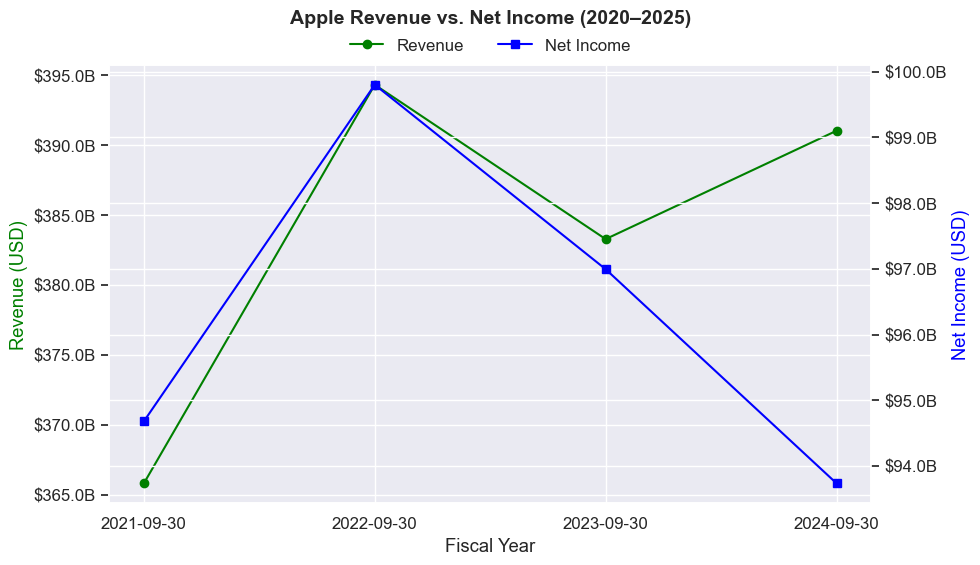

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Use Seaborn darkgrid style
sns.set_theme(style='darkgrid', context='notebook', font_scale=1.1)

# Load data
financials = pd.read_sql(
    text("""
        SELECT i.date, i.total_revenue, i.net_income, b.total_assets 
        FROM income_statement i
        JOIN balance_sheet b ON i.date = b.date
    """),
    engine
)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Revenue
ax1.plot(financials['date'], financials['total_revenue'], color='green', marker='o', label='Revenue')
ax1.set_ylabel('Revenue (USD)', color='green')
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x/1e9:.1f}B'))

# Plot Net Income on secondary axis
ax2 = ax1.twinx()
ax2.plot(financials['date'], financials['net_income'], color='blue', marker='s', label='Net Income')
ax2.set_ylabel('Net Income (USD)', color='blue')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x/1e9:.1f}B'))

# Title and axis label
ax1.set_title("Apple Revenue vs. Net Income (2020–2025)", fontsize=14, fontweight='bold', pad=30)
ax1.set_xlabel("Fiscal Year")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2, labels1 + labels2,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.92),  # just below the title
    ncol=2,
    frameon=False
)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # allows space for title and legend

# Save and show plot
plt.savefig('../plots/revenue_vs_net_income_seaborn_darkgrid.png', dpi=300, bbox_inches='tight')
plt.show()


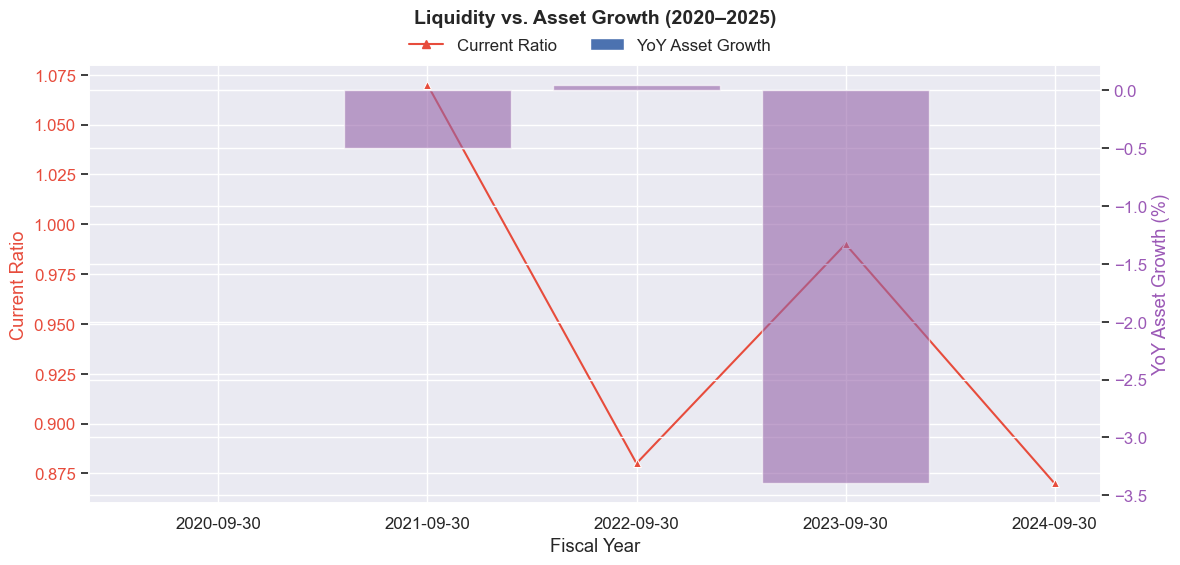

In [27]:
#Current Ratio vs YoY Asset Growth Plot
import matplotlib.pyplot as plt
import seaborn as sns


# Apply seaborn darkgrid style
sns.set_theme(style='darkgrid', context='notebook', font_scale=1.1)

# Sort data by date
current_ratio_df = current_ratio_df.sort_values("date")
balance_df = balance_df.sort_values("date")

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Current Ratio (line)
line = sns.lineplot(
    data=current_ratio_df,
    x='date',
    y='current_ratio',
    color='#e74c3c',
    marker='^',
    ax=ax1
)
line_line, = ax1.plot([], [], color='#e74c3c', marker='^', label='Current Ratio')  # Manual handle for legend
ax1.set_ylabel('Current Ratio', color='#e74c3c')
ax1.tick_params(axis='y', labelcolor='#e74c3c')

# Plot YoY Asset Growth (bar)
bar = sns.barplot(
    data=balance_df,
    x='date',
    y='yoy_asset_growth',
    color='#9b59b6',
    alpha=0.6,
    ax=(ax2 := ax1.twinx())
)
bar_bar = ax2.bar([], [], color='#9b59b6', alpha=0.6, label='YoY Asset Growth')  # Manual handle for legend
ax2.set_ylabel('YoY Asset Growth (%)', color='#9b59b6')
ax2.tick_params(axis='y', labelcolor='#9b59b6')

# Title and x-axis label
ax1.set_title("Liquidity vs. Asset Growth (2020–2025)", fontsize=14, fontweight='bold', pad=30)
ax1.set_xlabel('Fiscal Year')

# Combined legend placed below the title
fig.legend(
    handles=[line_line, bar_bar],
    loc='upper center',
    bbox_to_anchor=(0.5, 0.92),
    ncol=2,
    frameon=False
)

# Layout tweaks
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Save and show
plt.savefig('../plots/liquidity_vs_growth_cleaned.png', dpi=300, bbox_inches='tight')
plt.show()
